# **Simple Filters for Motion Blur**

In this notebook we will cover a simple weiner filter to restor images corrupted from Motion Blur

In [132]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

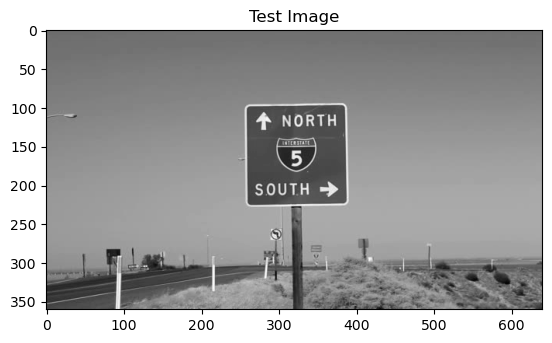

In [133]:
image = cv2.cvtColor(cv2.imread('sign.jpg'), cv2.COLOR_BGR2GRAY)

plt.imshow(image, cmap='gray')
plt.title("Test Image");

Get Blurr transform

In [134]:
def get_motion_blur_transform(img_rows, img_cols, a, b, T):
    """
        Obtains Motion Blur Transform
        Inputs:
            img_rows
            img_cols
            a - horizontal blur factor
            b - vertical blur factor
            T - exposure time
        Outputs:
            H - Motion Blur Transform in Fourier Domain
    """
    # get spatial Frequencies in range [-0.5, 0.5]
    u = np.fft.fftfreq(img_cols)[None, :]
    v = np.fft.fftfreq(img_rows)[:, None]
    c = np.pi*(u*a + v*b)  # common part
    H = T/c * np.sin(c) * np.exp(-1j*c)
    H[c == 0] = 1  # account for div by zero

    return H

In [135]:
img_rows, img_cols = image.shape
H = get_motion_blur_transform(img_rows, img_cols, a=5, b=10, T=1)

C:\Users\itber\AppData\Local\Temp\ipykernel_80464\639328475.py:17: RuntimeWarning: divide by zero encountered in divide
  H = T/c * np.sin(c) * np.exp(-1j*c)
C:\Users\itber\AppData\Local\Temp\ipykernel_80464\639328475.py:17: RuntimeWarning: invalid value encountered in multiply
  H = T/c * np.sin(c) * np.exp(-1j*c)


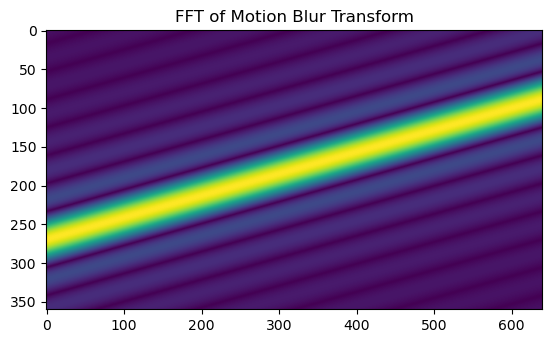

In [136]:
plt.imshow(np.abs(np.fft.fftshift(H)))
plt.title("FFT of Motion Blur Transform");

Compute FFT of original image f

In [137]:
F = np.fft.fft2(image)

Perform Blurring Transformation to obtain blurred image g

In [138]:
G = F*H
g = np.fft.ifft2(G)
blurred = cv2.normalize(np.abs(g), None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32FC1)

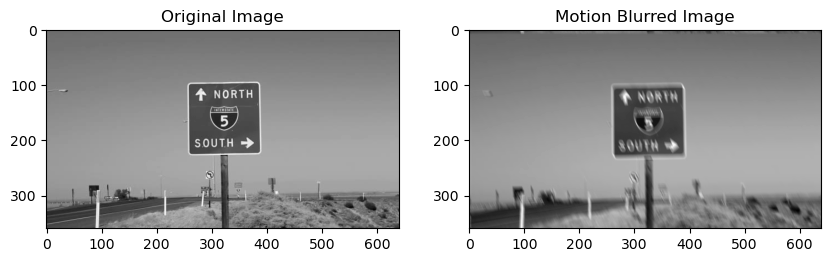

In [139]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original Image")
ax[1].imshow(blurred, cmap='gray')
ax[1].set_title("Motion Blurred Image");

Construct Weiner Filter

In [140]:
k = 0.01 # hyperparameter
W = np.conjugate(H)/((np.abs(H)**2) + k)

Perform Weiner Filtering

In [141]:
F_hat = W*G

In [142]:
f_hat = np.fft.ifft2(F_hat)
restored = cv2.normalize(np.abs(f_hat), None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32FC1)

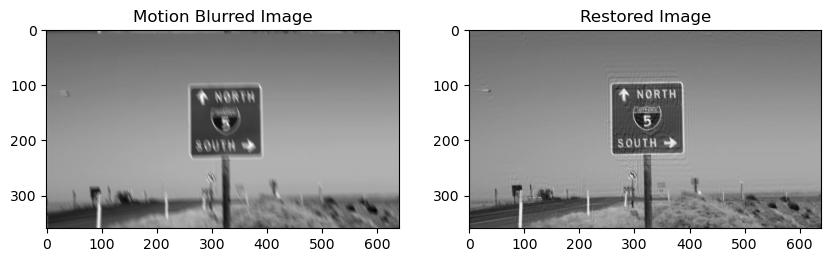

In [143]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(blurred, cmap='gray')
ax[0].set_title("Motion Blurred Image");
ax[1].imshow(restored, cmap='gray')
ax[1].set_title("Restored Image");

Check Errors

In [144]:
np.round(np.sum(np.square(image/255 - blurred)), 4), np.round(np.sum(np.square(image/255 - restored)), 4)

(1527.8546, 153.024)

## Use a different image

We were able to restore the image, but we already knew the blurring function. Let's try this again on a different image

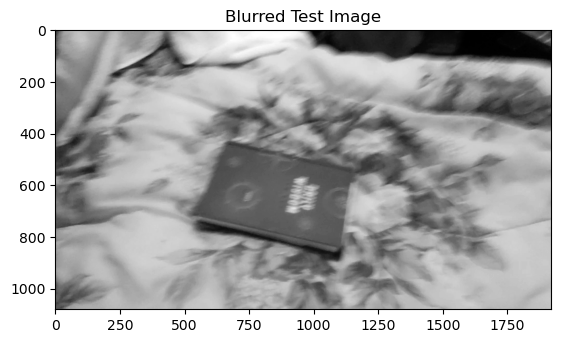

In [165]:
# blurred_image = cv2.cvtColor(cv2.imread("motorcycle.png"), cv2.COLOR_BGR2GRAY)
# blurred_image = cv2.cvtColor(cv2.imread("cars.png"), cv2.COLOR_BGR2GRAY)
blurred_image = cv2.cvtColor(cv2.imread("book2.png"), cv2.COLOR_BGR2GRAY)

# # OPTIONAL: Sharpen before Wiener Filtering
# kernel = np.array([
#     [0, -1, 0],
#     [-1, 5, -1],
#     [0, -1, 0]
# ])
# blurred_image = cv2.filter2D(blurred_image/255, -1, kernel)
# blurred_image = cv2.convertScaleAbs(blurred_image, None, 255, 0)

plt.imshow(blurred_image, cmap='gray')
plt.title("Blurred Test Image");

Get Crop if desired

In [166]:
# blurred_image = blurred_image[200:1100, 550:1200]

OPTIONAL: Perform unsharp masking

In [167]:
# gaus_blur = cv2.GaussianBlur(blurred_image, ksize=(7,7), sigmaX=7)
# blurred_image = cv2.addWeighted(blurred_image, 2.0, gaus_blur, -1.0, 0.0)

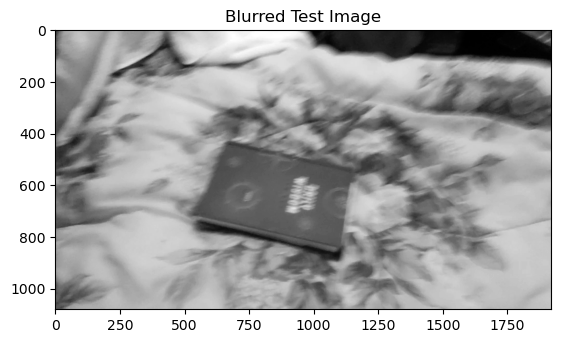

In [168]:
plt.imshow(blurred_image, cmap='gray')
plt.title("Blurred Test Image");

In [169]:
blurred_image.shape

(1080, 1920)

Get FFT of blurred image

In [170]:
G = np.fft.fft2(blurred_image)

Get guesstimated blurr transform

In [339]:
img_rows, img_cols = blurred_image.shape
H = get_motion_blur_transform(img_rows, img_cols, a=3.0, b=1.0, T=1.0)

C:\Users\itber\AppData\Local\Temp\ipykernel_80464\639328475.py:17: RuntimeWarning: divide by zero encountered in divide
  H = T/c * np.sin(c) * np.exp(-1j*c)
C:\Users\itber\AppData\Local\Temp\ipykernel_80464\639328475.py:17: RuntimeWarning: invalid value encountered in multiply
  H = T/c * np.sin(c) * np.exp(-1j*c)


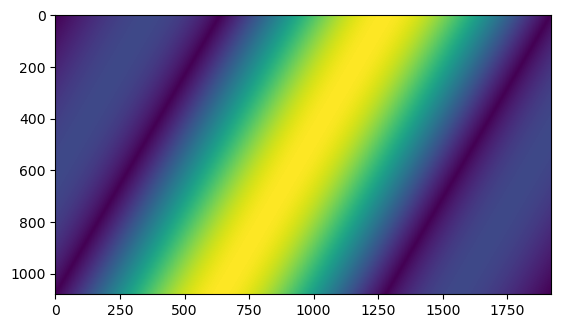

In [340]:
plt.imshow(np.fft.fftshift(np.abs(H)));

Construct Weiner Filter

In [341]:
k = 0.2 # hyperparameter
W = np.conjugate(H)/((np.abs(H)**2) + k)

Perform Wiener Filtering and obtain restored image

In [342]:
F_hat = W*G

In [343]:
f_hat = np.fft.ifft2(F_hat)
restored_image = cv2.normalize(np.abs(f_hat), None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32FC1)

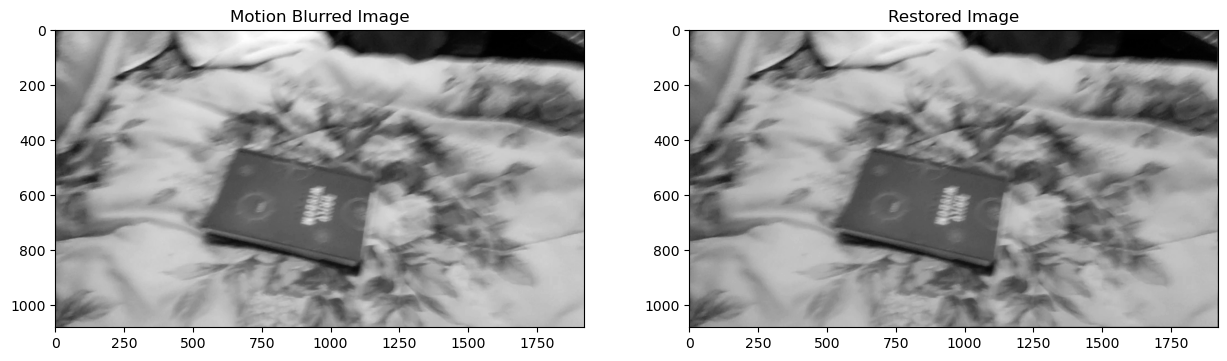

In [344]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(blurred_image, cmap='gray')
ax[0].set_title("Motion Blurred Image");
ax[1].imshow(restored_image, cmap='gray')
ax[1].set_title("Restored Image");

OPTIONAL: Sharpen after Wiener Filtering

In [334]:
kernel = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])
filtered = cv2.filter2D(restored_image, -1, kernel)
filtered = cv2.convertScaleAbs(filtered, None, 255, 0)

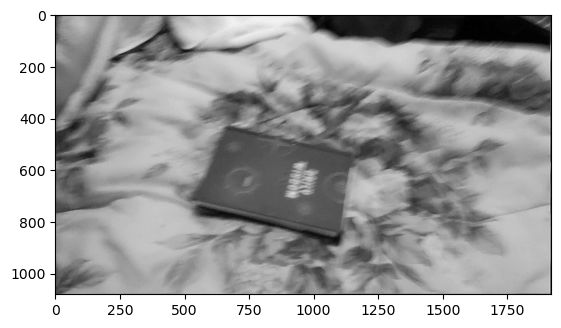

In [335]:
plt.imshow(filtered, cmap='gray')

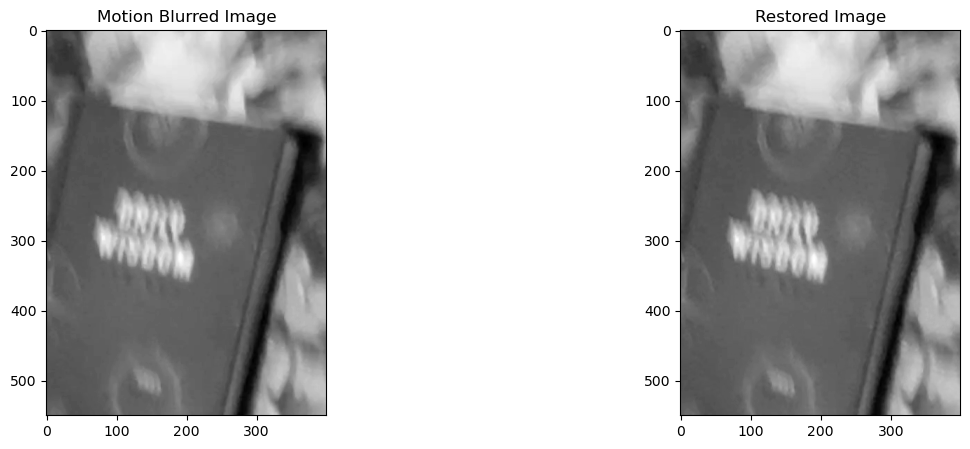

In [336]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(cv2.rotate(cv2.rotate(blurred_image[500:900, 700:1250], 1), 0), cmap='gray')
ax[0].set_title("Motion Blurred Image");
ax[1].imshow(cv2.rotate(cv2.rotate(restored_image[500:900, 700:1250], 1), 0), cmap='gray')
ax[1].set_title("Restored Image");

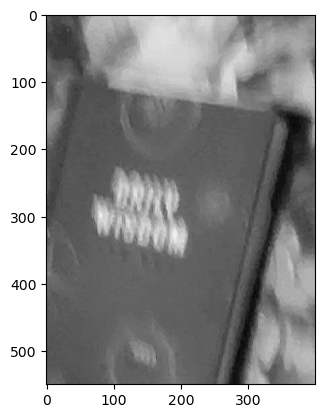

In [337]:
plt.imshow(cv2.rotate(cv2.rotate(filtered[500:900, 700:1250], 1), 0), cmap='gray')

Display Liscense Plates in cars image

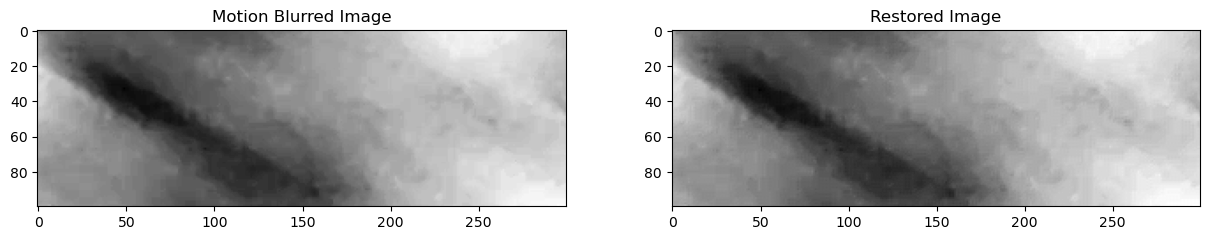

In [29]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(blurred_image[525:625, 1600:1900], cmap='gray')
ax[0].set_title("Motion Blurred Image");
ax[1].imshow(restored_image[525:625, 1600:1900], cmap='gray')
ax[1].set_title("Restored Image");

In [664]:
cv2.imwrite('restored_cars.png', filtered)

True

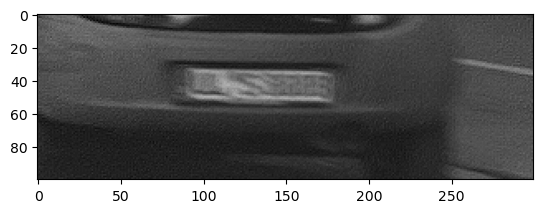

In [665]:
plt.imshow(filtered[525:625, 1600:1900], cmap='gray');

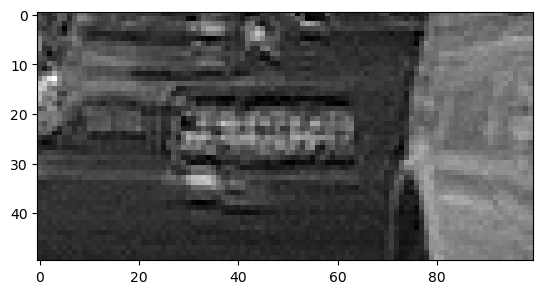

In [650]:
plt.imshow(filtered[450:500, 1300:1400], cmap='gray');

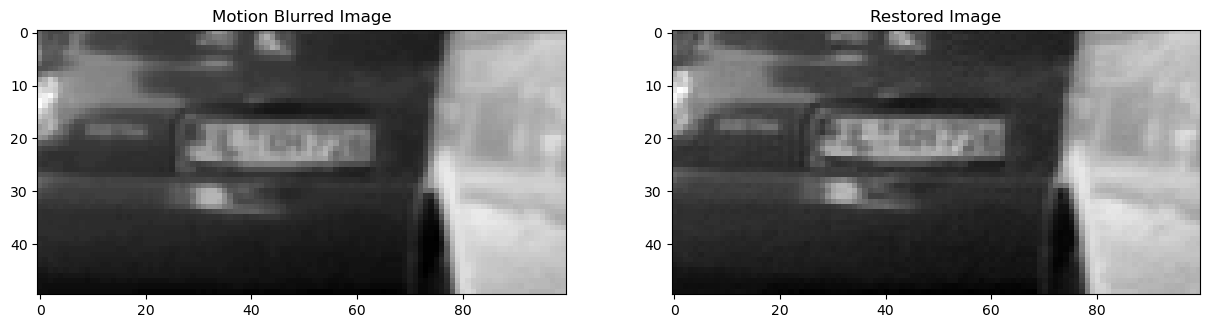

In [625]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(blurred_image[450:500, 1300:1400], cmap='gray')
ax[0].set_title("Motion Blurred Image");
ax[1].imshow(restored_image[450:500, 1300:1400], cmap='gray')
ax[1].set_title("Restored Image");